# Muon tomography

Muon tomography is the process in which a volume is reconstructed given a set of projections (muograms) taken in different angles across the structure.

### Import libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

### Utils

In [2]:
def normalize(x, a, b, x0 , x1):
    return a + (b-a)*(x - x0) / (x1 - x0)

In [3]:
def measure(lat1, lon1, lat2, lon2):
    R = 6378.137                                                      # Radius of earth in KM
    dLat = lat2 * np.pi / 180 - lat1 * np.pi / 180                    # Distance of the Latitude coordinates
    dLon = lon2 * np.pi / 180 - lon1 * np.pi / 180                    # Distance of the Longitude coordinates 
    a = np.sin(dLat/2) * np.sin(dLat/2) + np.cos(lat1 * np.pi / 180)  * np.cos(lat2 * np.pi / 180) * np.sin(dLon/2) * np.sin(dLon/2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = R * c                                                         # Total distance
    return d * 1000 # meters

## Muograms

Muograms are obtained by MUYSC's muography module. This are the projections used in the tomographic reconstruction 

In [4]:
# This data is found in muogram metadata
region = [-75.4,-75.37,4.47,4.5]
cenit = np.linspace(20,-8,5)
azimut = np.linspace(-50,50,5)
h0 = 2495
hmax = 2758

In [5]:
def get_data(path):
    data_list = sorted(os.listdir(path)) # Sorted list of file names
    data = np.array([np.loadtxt(path+'/'+data, comments='#') for data in data_list])/1000 # Read files in km
    return data, data_list

In order for this function to operate properly, the directory must exclusively consist of muogram files.

In [6]:
path = '/home/kevin/Documentos/muograms3/'
data, data_list = get_data(path)
print(data.shape)

(42, 100, 100)


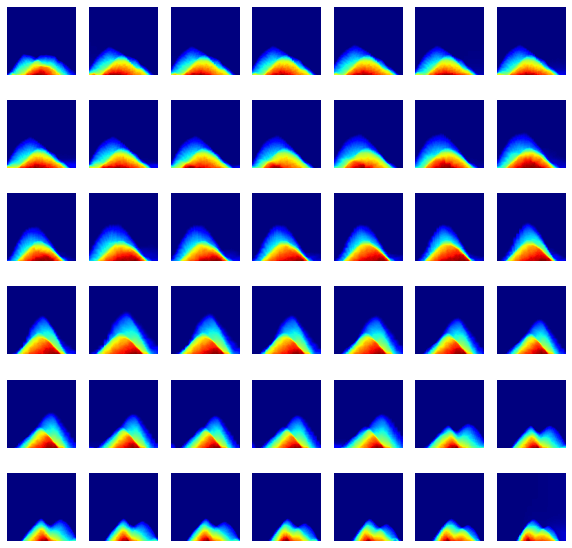

In [7]:
plt.figure(figsize=(10,10))
for i in range(len(data)):
    plt.subplot(6,7,i+1)
    plt.imshow(data[i],cmap='jet')
    plt.axis('off')

## Coordinates

With the version of MUYSC being used, the coordinates are contained in a separate file that includes the latitude and longitude of each observation point, as well as the reference point.

In other versions, the coordinates are included as metadata within the file containing the muogram, so the function to obtain them is different.

In [8]:
def get_coords(path):
    Pp = [4.48666667,-75.38878788] # Coordinate of the reference point
    Pos = np.loadtxt(path) # Read file with coordinates of the observation points
    return np.insert(Pos,0,np.array([Pp]),axis=0) # Insert the reference point at the start of array

In [9]:
points = get_coords('/home/kevin/Documentos/Tesis/Files/coordinates5.dat')
print(points.shape)

(43, 2)


In [10]:
def plot_coords(points, region, heightmap, s=50, c='b', onmap=True):
    # Normalize coordinates to pixels
    x = normalize(points[:, 1], 0, heightmap.shape[1], region[0], region[1])
    y = normalize(points[:, 0], heightmap.shape[0], 0, region[2], region[3])

    # Plot heightmap and coordinates
    plt.imshow(heightmap, cmap='jet')
    plt.colorbar(label='m.a.s.l')
    plt.scatter(x, y, s=s, c=c)

    # Generate axis labels and tick locations
    longlat = [np.linspace(region[i], region[i+1], 4) for i in range(0, len(region)-1, 2)]
    plt.xticks(np.linspace(0, heightmap.shape[1]-1, len(longlat[0])), np.round(longlat[0], 3))
    plt.yticks(np.linspace(heightmap.shape[0]-1, 0, len(longlat[1])), np.round(longlat[1], 3))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

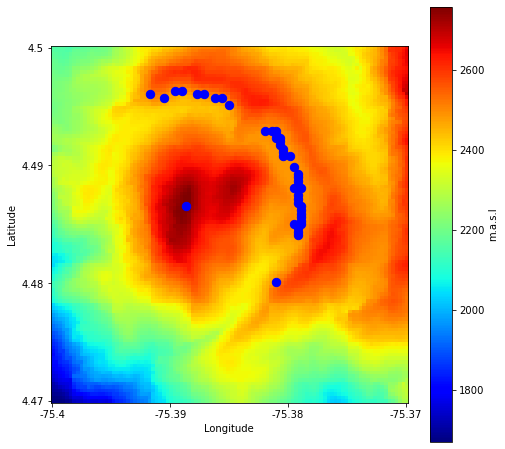

In [11]:
plt.figure(figsize=(8,8))
heightmap = np.loadtxt('/home/kevin/Documentos/Tesis/Files/heightmap.dat')
plot_coords(points,region,heightmap,s=70,c='b')

## Angles

Angles are the other required data for tomographic reconstruction. Thanks to the previously acquired coordinates, these can be calculated using the formula:

$$ \theta_i = \arctan\left(\frac{y_i-y_0}{x_i-x_0}\right) $$

In [12]:
def get_angles(points):
    pp = points[0] # Reference point
    return np.array([np.arctan2((po - pp)[0],(po - pp)[1])-(np.pi/2) for po in points[1:]])

In [13]:
angles = get_angles(points)
print(angles.shape,angles*180/np.pi)

(42,) [-130.03026637 -104.47033653 -102.72440061 -100.95411005  -99.46231199
  -98.88065014  -97.12500908  -95.35581955  -93.5763307   -91.78990876
  -90.          -88.1523917   -86.30861793  -84.4724657   -81.11934986
  -80.53768801  -79.04594874  -77.27565742  -75.52972066  -73.81081007
  -69.86371694  -64.2306979   -62.59245318  -60.94542563  -59.34936276
  -56.82152165  -55.3048805   -53.8418492   -52.76520245  -51.34022864
  -49.96977798  -48.81411388  -46.33226278  -23.19856606  -18.43492992
  -14.93140149   -9.16233746   -5.5275343     1.78990876    5.35581955
   11.30992035   17.87867878]


### Equidistance

Since the library only takes the angles of the points, it assumes that they are located on a circle around the reference point with their corresponding angle. In other words, it assumes points are equidistant to the reference point.

In [14]:
def circle_points(angles,points):
    R = 1 # Circle radius
    cpoints = np.array([R*np.cos(-angles),R*np.sin(-angles)]).T # Create points according to angles
    
    # Normalize points to original coordinates
    cpoints[:,1] = normalize(cpoints[:,1],np.min(points[:,1]),np.max(points[:,1]),np.min(cpoints[:,1]),np.max(cpoints[:,1]))
    cpoints[:,0] = normalize(cpoints[:,0],np.min(points[:,0]),np.max(points[:,0]),np.min(cpoints[:,0]),np.max(cpoints[:,0]))
    
    return cpoints

Text(0.5, 1.0, 'Tomopy points location')

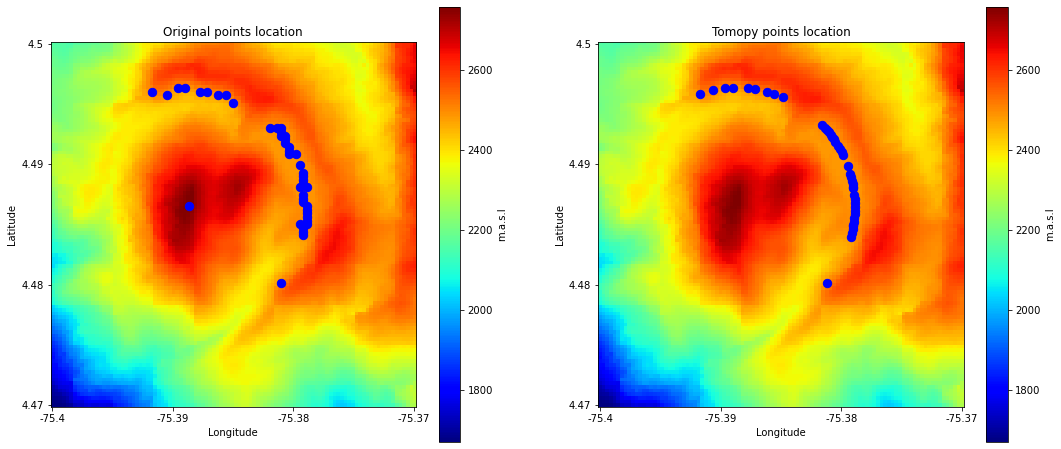

In [15]:
plt.figure(figsize=(18,8))
heightmap = np.loadtxt('/home/kevin/Documentos/Tesis/Files/heightmap.dat')
plt.subplot(1,2,1)
plot_coords(points,region,heightmap,s=70,c='b')
plt.title('Original points location')
p = circle_points(angles,points)
plt.subplot(1,2,2)
plot_coords(p,region,heightmap,s=70,c='b')
plt.title('Tomopy points location')

##  Reconstruction

The reconstruction is performed using the TomoPy library, which requires as main arguments the projections, the angles where they were obtained, and the reconstruction algorithm. As seen in the SheppLogan notebook, the selected algorithm is the Algebraic Reconstruction Technique (ART), which solves a system of linear equations $Ax=b$, where:

- $A$ is a sparse matrix $M \times N$ ($M$ being the number of individual values in the projection, and $N$ the number of voxels in the volume to be reconstructed).
- $x$ is the vectorized volume to be reconstructed.
- $b$ is a projection.

The solution to this system of equations is:


$$ x^{k+1}=x^{k}+\lambda _{k}{\frac {b_{i}-\langle a_{i},x^{k}\rangle }{\|a_{i}\|^{2}}}a_{i}^{T} $$

Where:

- $i = k \ \text{mod} (M) + 1$
- $a_i$ is the i-th row of $A$
- $b_i$ is the i-th component of $b$
- $k=0,1,2,...$

This algorithm is iterative, where all projections are used in one iteration.

In [16]:
import tomopy
def get_recon(data,angles,alg='art',iters=1,negatives=True, idx=None):
    idx = idx if idx is not None else slice(None)
    rec = tomopy.recon(data[idx],angles[idx],algorithm=alg,num_iter=iters) # Tomopy reconstruction
    if negatives:
        rec[rec<0]=0 # Remove negative values (non observaded values)
    return rec

In [17]:
rec = get_recon(data,angles)
print(rec.shape)

(100, 100, 100)


In [18]:
def get_recviews(rec,norm=True,slices=None):
    if slices == None:
        views = [np.sum(rec,axis=i)for i in range(len(rec.shape))] # Take views of all structure
    else:
        views = [rec[slices[2]],rec[:,slices[0]],rec[:,:,slices[1]]] # Take views from desired slices
    if norm:
        views[0] = normalize(views[0],0,1,np.min(views[0]),np.max(views[0])) # Normalize between 0 to 1
    return views

In [19]:
recviews = get_recviews(rec)

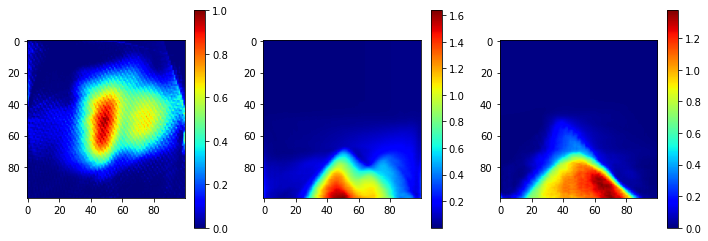

In [20]:
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(recviews[i],cmap='jet')
    plt.colorbar()

It's possible to reconstruction with lesser points, using remove_points function, which returns index array of number of points desired to reconstruct (as equally spaced as possible) or manually giving an array index of desired points.

In [21]:
def remove_points(angles,n):
    interval = abs(np.max(angles)-np.min(angles))/n # Interval of n equal parts
    idxs = []
    p = 0
    sign = 1
    for i in range(n+1):
        idx = np.abs(angles - (np.min(angles) + i*interval)).argmin() # Index of angle closest to the interval
        if idx in idxs: # If the closest angle is the same, add the next or last one
            idx = np.setdiff1d(np.arange(len(angles)),idxs)[p]
            sign = sign*-1
            p = p + sign
        idxs.append(idx)
    return np.array(sorted(idxs))[1:]

In [22]:
idx = remove_points(angles,8)
len(idx)

8

In [23]:
rec = get_recon(data,angles,idx=idx)
print(rec.shape)

(100, 100, 100)


In [24]:
recviews = get_recviews(rec)

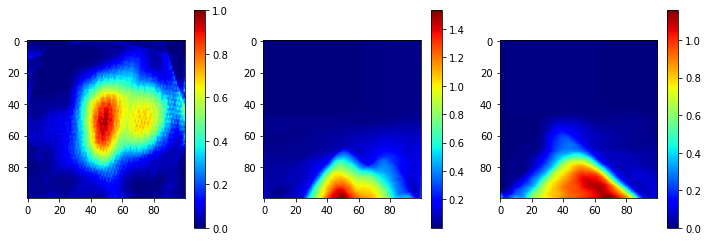

In [25]:
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(recviews[i],cmap='jet')
    plt.colorbar()

It's also possible to get specific slices of the reconstruction. Slices are given as an array of indexes in [x,y,z].

In [26]:
recviews = get_recviews(rec,slices=[40,60,80])

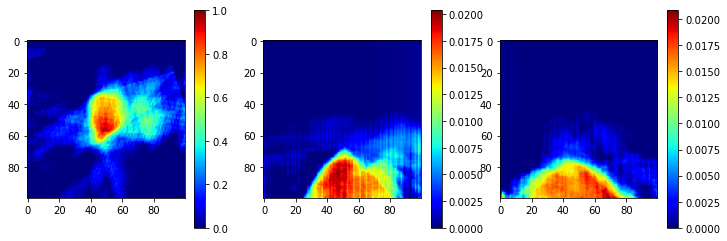

In [27]:
plt.figure(figsize=(12,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(recviews[i],cmap='jet')
    plt.colorbar()

In [28]:
def get_recregion(points,h0,hmax,cenit):
    d = np.mean([np.sqrt((po[0]-points[0,0])**2 + (po[1]-points[0,1])**2) for po in points[1:]]) # Mean distance between points and reference point
    # Region corners estimation
    latmax = d*np.sin(np.pi/4)+points[0,0]
    latmin = points[0,0]-d*np.sin(np.pi/4)
    longmax = d*np.cos(np.pi/4)+points[0,1]
    longmin = points[0,1]-d*np.cos(np.pi/4)

    # Minimum observation height estimation
    dm = measure(latmax,longmax,points[0,0],points[0,1]) # Distancie in meters between calculated coordinate and reference point
    theta = np.arctan((hmax-h0)/dm)
    h = dm*np.tan(theta-abs(cenit[-1]*np.pi/180)) + h0
    
    return [longmin,longmax,latmin,latmax],h

In [29]:
def get_oriviews(path,data,angles,cenit):
    sup = np.loadtxt(path) # Top view (height map)
    indexes = []
    for theta in [0,np.pi/2]:
        index = np.abs(np.abs(angles)-theta).argmin() # Finds angles closest to 0 and 90 degrees
        indexes.append(index)

    recregion, h = get_recregion(points, h0, hmax, cenit)
    sup[sup<h]=h # Discard heights lower than the minimum height that the detector visualizes
    sup = normalize(sup, 0, 1, np.min(sup), np.max(sup)) # Normalize values between 0 and 1 for comparison
    return [sup, *data[indexes]], recregion


In [30]:
path2 = '/home/kevin/Documentos/Tesis/Files/heightmap2.dat'
oriviews,recregion = get_oriviews(path2,data,angles,cenit)

In [31]:
def get_recaxis(recregion,cenit,azimut,shape,i,iserror=False):
    if i == 0: # Top view
        label = ''
        if iserror:
            label = r'$\varepsilon$'
        longz = np.linspace(recregion[0],recregion[1],4)
        latz = np.linspace(recregion[2],recregion[3],4)
        plt.xticks(np.linspace(0,shape[1]-1,len(longz)),np.round(longz,3))
        plt.xlabel('Longitude')
        plt.yticks(np.linspace(shape[0]-1,0,len(latz)),np.round(latz,3))
        plt.ylabel('Latitude')
        plt.colorbar(label=label)
    else: # Front and side view
        label = 'Rock thickness'
        if iserror:
            label = r'$\varepsilon$'
        plt.xticks(np.linspace(0,shape[1]-1,len(azimut)),np.round(azimut,2))
        plt.xlabel(r'$\Delta\phi$-azimuth [degree]')
        plt.yticks(np.linspace(0,shape[0]-1,len(cenit)),np.round(cenit,2))
        plt.ylabel(r'$\Delta\phi$-zenith [degree]')
        plt.colorbar(label=f'{label} [km]')

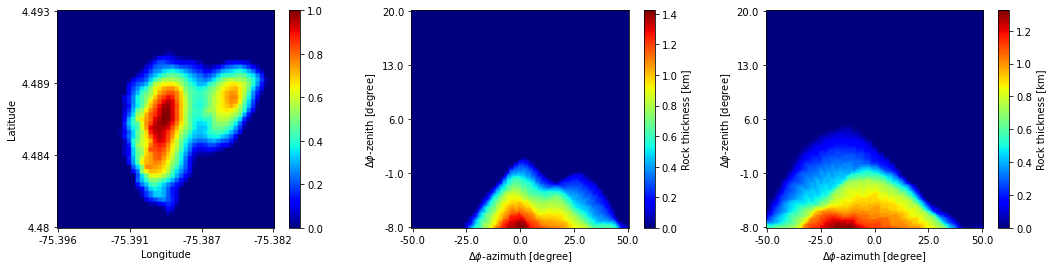

In [32]:
plt.figure(figsize=(18,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(oriviews[i],cmap='jet')
    get_recaxis(recregion,cenit,azimut,oriviews[i].shape,i)